In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=e5527a782d3a47671445249372ed420802162f7b3bc7fe40c9ee1dc24f249a2e
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics
from IPython.display import clear_output
import time
import datetime
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from ta import add_all_ta_features
from ta.utils import dropna

import tensorflow as tf
from tensorflow import keras

In [ ]:
class price_sim:

  """
    A Python class for simulating and analyzing financial price data using Geometric Brownian Motion (GBM).

    This class provides a set of functions to load historical price data, calculate returns, simulate GBM,
    and visualize the results. It includes functionalities for both regular simulation and backtesting.

    Attributes:
        - ticker (str): Ticker symbol for the financial instrument.
        - start_date (list): Start date [year, month, day] for historical data loading.
        - end_date (list/str): End date [year, month, day] or 'today' for historical data loading.
        - interval (str): Data interval (e.g., '1d') for historical data loading.
        - predicted_period (int): Number of periods for future price simulation.
        - backtesting (bool): True for backtesting, False for regular simulation.

    Functions:
        - data_loading: Compiles historical price data from Yahoo Finance for a specified ticker.
        - returnify: Calculates simple returns for provided financial data.
        - log_returnify: Calculates log returns for provided financial data.
        - GBM_params: Calculates mean and standard deviation of returns.
        - GBM: Simulates Geometric Brownian Motion for a given set of parameters.
        - plot_paths: Plots realizations of GBM along with actual exchange rates.
        - plot_paths_on_profit_space: Plots realizations of GBM with profit space boundaries.
        - pipeline: Executes the complete pipeline for GBM simulation and visualization.

    Note:
        - The class assumes the use of Pandas for handling financial data and NumPy for numerical operations.
        - Visualization functionalities use Matplotlib for plotting.
  """

  def data_loading(self, ticker, start_date, end_date, interval):

      """
      - Calculates log returns for the provided financial data.

    - Parameters:
          - FX_data (Pandas DataFrame): Financial data.
          - date_col (str, optional): Column containing dates.

      - Returns:
        - Pandas DataFrame with dates and corresponding log returns.
      """

      self.ticker = ticker
      self.start_date = start_date
      self.end_date = end_date
      self.interval = interval

      yh_start_date = int(time.mktime(datetime.datetime(self.start_date[0], self.start_date[1], self.start_date[2], 23, 59).timetuple()))

      if self.end_date == 'today':
        yh_end_date = int(time.mktime(datetime.datetime.now().timetuple()))
      else:
        yh_end_date = int(time.mktime(datetime.datetime(self.end_date[0], self.end_date[1], self.end_date[2], 23, 59).timetuple()))

      query_string1 = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={yh_start_date}&period2={yh_end_date}&interval={self.interval}&events=history&includeAdjustedClose=true'

      FX_data = pd.read_csv(query_string1)
      FX_data['Adj Close'] = FX_data['Adj Close']

      return FX_data

  def returnify(self, FX_data, date_col = None):

      """
      - Calculates simple returns for the provided financial data.

     - Parameters:
          - FX_data (Pandas DataFrame): Financial data.
          - date_col (str, optional): Column containing dates.

      - Returns:
          - Pandas DataFrame with dates and corresponding returns.
      """

      self.FX_data = FX_data
      self.date_col = date_col

      if self.date_col != None:
        prices = self.FX_data.loc[:, self.FX_data.columns != self.date_col]
        dates = self.FX_data[date_col]
        returns = prices / prices.shift(1) - 1
        returnified = pd.concat([dates, returns], axis = 1,)

      else:
        prices = self.FX_data
        returns = prices / prices.shift(1) - 1
        returnified = returns

      return returnified

  def log_returnify(self, FX_data, date_col = None):

      """
    - Calculates log returns for the provided financial data.

    - Parameters:
        - FX_data (Pandas DataFrame): Financial data.
        - date_col (str, optional): Column containing dates.

    - Returns:
        - Pandas DataFrame with dates and corresponding log returns.
      """

      self.FX_data = FX_data
      self.date_col = date_col

      if self.date_col != None:
        prices = self.FX_data.loc[:, self.FX_data.columns != self.date_col]
        dates = self.FX_data[self.date_col]
        returns = np.log(prices) - np.log(prices.shift(1))
        returnified = pd.concat([dates, returns], axis = 1,)

      else:
        prices = self.FX_data
        returns = np.log(prices) - np.log(prices.shift(1))
        returnified = returns

      return returnified

  def streak_logic(self, last_streak, t0_value, tm1_value):

      if ((t0_value > 0) and (tm1_value >0)) or ((t0_value < 0) and (tm1_value < 0)):
        last_streak +=1
      elif ((t0_value > 0) and (tm1_value < 0)) or ((t0_value < 0) and (tm1_value > 0)):
        last_streak = 1
      elif t0_value == 0:
        last_streak = last_streak

      return last_streak

  def streak_counter(self, pd_series):
      streak = 0
      streak_series = pd.Series(1)

      for i in range(1, len(pd_series)):
        t0_value = pd_series[i]
        tm1_value = pd_series[i-1]

        streak = self.streak_logic(streak, t0_value, tm1_value)

        streak_series = pd.concat([streak_series, pd.Series(streak)], axis = 1, ignore_index= True)

      return streak_series

  def GBM_params(self, returns):

      """
    - Calculates the mean (mu) and standard deviation (sigma) of returns.

    - Parameters:
        - returns (Pandas Series): Financial returns.

    - Returns:
        - Tuple (mu, sigma) representing mean and standard deviation.
      """

      self.returns = returns

      mu = self.returns.describe().at['mean']
      sigma = self.returns.describe().at['std']

      return mu, sigma

  def GBM(self, mu, sigma, S0, steps, n_paths, plot = 'N', pandas = 'Y'):

      """
    - Simulates Geometric Brownian Motion (GBM) for a given set of parameters.

    - Parameters:
        - mu (float): Mean of returns.
        - sigma (float): Standard deviation of returns.
        - S0 (float): Initial stock price.
        - steps (int): Number of time steps.
        - n_paths (int): Number of simulation paths.
        - plot (str): 'Y' to plot simulation, 'N' otherwise.
        - pandas (str): 'Y' to return Pandas DataFrame, 'N' for NumPy array.

    - Returns:
        - Pandas DataFrame or NumPy array representing GBM simulation.
      """

      self.mu = mu
      self.sigma = sigma
      self.S0 = S0
      self.steps = steps
      self.n_paths = n_paths
      self.plot = plot
      self.pandas = pandas

      T = 1

      # calc each time step
      dt = T/self.steps

      # simulation using numpy arrays
      St = np.exp(
          (self.mu - self.sigma ** 2 / 2) * dt
          + self.sigma * np.random.normal(0, np.sqrt(dt), size=(self.n_paths,self.steps)).T
      )

      # include array of 1's
      St = np.vstack([np.ones(self.n_paths), St])

      # multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0).
      St = self.S0 * St.cumprod(axis=0)

      if self.plot == 'Y':
        # Define time interval correctly
        time = np.linspace(0,T,self.steps+1)

        # Require numpy array that is the same shape as St
        tt = np.full(shape=(self.n_paths,self.steps+1), fill_value=time).T

        plt.plot(tt, St)
        plt.xlabel("Years $(t)$")
        plt.ylabel("Stock Price $(S_t)$")
        plt.title(
            "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(self.S0, self.mu, self.sigma)
        )
        plt.show()

      if self.pandas == 'Y':
        output_St = pd.DataFrame(St)
      else:
        output_St = St

      return output_St

  def plot_paths(self, sim_df, FX_df, predicted_period, backtesting = False):

    """
    - Plots realizations of Geometric Brownian Motion along with actual exchange rates.

    - Parameters:
        - sim_df (Pandas DataFrame): Simulated GBM data.
        - FX_df (Pandas Series): Actual exchange rate data.
        - predicted_period (int): Number of predicted periods.
        - backtesting (bool): True for backtesting, False for regular simulation.
    """

    self.ticker = 'USD-Y'

    self.sim_df = sim_df
    self.FX_df = FX_df
    self.predicted_period = predicted_period
    self.backtesting = backtesting

    time_space = np.linspace(0,1,self.predicted_period+1)
    tt = np.full(shape=(10000, self.predicted_period + 1), fill_value=time_space).T
    tt_fx = np.full(shape=(1, self.predicted_period + 1), fill_value=time_space).T

    temp = self.FX_df[self.FX_df.index >= len(self.FX_df)-self.predicted_period-1].reset_index(drop = True)

    if self.backtesting == True:
      plot_df = self.sim_df
    else:
      df_nan = pd.DataFrame(np.nan, index=range(self.predicted_period), columns=range(len(self.sim_df.columns)))
      plot_df = pd.concat([df_nan, self.sim_df]).reset_index(drop = True)
      temp = pd.concat([temp, df_nan]).reset_index(drop = True)
      time_space = np.linspace(0,1,2*self.predicted_period+1)
      tt = np.full(shape=(10000, 2*self.predicted_period + 1), fill_value=time_space).T
      tt_fx = np.full(shape=(1, 2*self.predicted_period + 1), fill_value=time_space).T

    fig = plt.figure(figsize=(8,5))
    plt.plot(tt, plot_df)
    #plt.plot(tt_fx, temp)#, linewidth = 1, c = 'k')
    plt.xlabel("Years $(t)$")
    plt.ylabel("Exchange Rate $(S_t)$")
    plt.title(
            "Realizations of Geometric Brownian Motion of {3}\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(round(self.S0,6), round(self.mu,6), round(self.sigma,6), self.ticker)
        )
    plt.grid()
    plt.show()

  def plot_paths_on_profit_space(self, sim_df, FX_df, predicted_period, avg_returns, backtesting = False):

    """
    - Plots realizations of Geometric Brownian Motion with profit space boundaries.

    - Parameters:
        - sim_df (Pandas DataFrame): Simulated GBM data.
        - FX_df (Pandas Series): Actual exchange rate data.
        - predicted_period (int): Number of predicted periods.
        - avg_returns (float): Average returns for profit space boundaries.
        - backtesting (bool): True for backtesting, False for regular simulation.
    """

    t_start = 0
    t_end = 1
    t_step = 1/predicted_period

    avg_fee_rate = avg_returns

    profit_space = pd.DataFrame(columns=['t','bounds_x1', 'bounds_x2'])
    profit_space['t'] = pd.Series(np.arange(t_start-t_step,t_end,t_step))

    bounds_x1 = pd.Series(profitability_bounds(FX_df.iloc[-predicted_period-1], 0))
    bounds_x2 = pd.Series(profitability_bounds(FX_df.iloc[-predicted_period-1], 0))


    for i in range(1, len(profit_space)):
        bounds_x1 = pd.concat([bounds_x1, pd.Series(profitability_bounds(FX_df.iloc[-predicted_period-1], (((1+avg_fee_rate)**i)-1))[0])])
        bounds_x2 = pd.concat([bounds_x2, pd.Series(profitability_bounds(FX_df.iloc[-predicted_period-1], (((1+avg_fee_rate)**i)-1))[1])])

    profit_space['bounds_x1'] = bounds_x1.reset_index(drop=True)
    profit_space['bounds_x2'] = bounds_x2.reset_index(drop=True)

    self.ticker = 'USD-Y'

    self.sim_df = sim_df
    self.FX_df = FX_df
    self.predicted_period = predicted_period
    self.backtesting = backtesting

    time_space = np.linspace(0,1,self.predicted_period+1)
    tt = np.full(shape=(10000, self.predicted_period + 1), fill_value=time_space).T
    tt_fx = np.full(shape=(1, self.predicted_period + 1), fill_value=time_space).T

    temp = self.FX_df[self.FX_df.index >= len(self.FX_df)-self.predicted_period-1].reset_index(drop = True)

    if self.backtesting == True:
      plot_df = self.sim_df
    else:
      df_nan = pd.DataFrame(np.nan, index=range(self.predicted_period), columns=range(len(self.sim_df.columns)))
      plot_df = pd.concat([df_nan, self.sim_df]).reset_index(drop = True)
      temp = pd.concat([temp, df_nan]).reset_index(drop = True)
      time_space = np.linspace(0,1,2*self.predicted_period+1)
      tt = np.full(shape=(10000, 2*self.predicted_period + 1), fill_value=time_space).T
      tt_fx = np.full(shape=(1, 2*self.predicted_period + 1), fill_value=time_space).T

    fig = plt.figure(figsize=(8,5))
    plt.plot(tt, plot_df)
    #plt.plot(tt_fx, temp)#, linewidth = 1, c = 'k')
    x = profit_space['t']
    y1 = profit_space['bounds_x1']
    y2 = profit_space['bounds_x2']

    plt.fill_between(x, y1, y2, alpha=0.4)
    plt.xlabel("Years $(t)$")
    plt.ylabel("Exchange Rate $(S_t)$")
    plt.title(
            "Realizations of Geometric Brownian Motion of {3}\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(round(self.S0,6), round(self.mu,6), round(self.sigma,6), self.ticker)
        )
    plt.grid()
    plt.show()

  def pipeline(self, predicted_period, FX_data = pd.DataFrame(), ticker = '', start_date = [], end_date = [], interval = '', backtesting = True, plot_sim = False,):

    """
    - Executes the complete pipeline for Geometric Brownian Motion simulation and visualization.

    - Parameters:
        - predicted_period (int): Number of predicted periods.
        - FX_data (Pandas DataFrame, optional): Historical price data.
        - ticker (str): Ticker symbol.
        - start_date (list): Start date [year, month, day].
        - end_date (list/str): End date [year, month, day] or 'today'.
        - interval (str): Data interval (e.g., '1d').
        - backtesting (bool): True for backtesting, False for regular simulation.
        - plot_sim (bool): True to plot the simulation, False otherwise.
    """

    self.ticker = ticker
    self.start_date = start_date
    self.end_date = end_date
    self.interval = interval
    self.predicted_period = predicted_period
    self.backtesting = backtesting

    if FX_data.empty:
        self.FX_data = self.data_loading(ticker = self.ticker,
                            start_date=self.start_date,
                            end_date=self.end_date,
                            interval=self.interval)
    else:
        self.FX_data = FX_data

    self.returns = self.log_returnify(FX_data = self.FX_data,
                            date_col = 'Date')

    self.mu, self.sigma = self.GBM_params(self.returns['Adj Close'])

    self.sim = self.GBM(
        mu = self.mu*(self.predicted_period**(1/2)),
        sigma = self.sigma*(self.predicted_period**(1/2)),
        S0 = self.FX_data.at[len(self.FX_data)-self.predicted_period-1, 'Adj Close'] if backtesting == True else self.FX_data.at[len(self.FX_data)-1, 'Adj Close'],
        #FX_data.at[len(FX_data)-predicted_period-1, 'Close'],
        steps = self.predicted_period,
        n_paths = 10000)
    self.sim_df = self.sim

    if plot_sim:
        self.plot_paths(
            sim_df = self.sim,
            FX_df = self.FX_data['Adj Close'],
            predicted_period = self.predicted_period,
            backtesting = self.backtesting)

    self.streaks = self.streak_counter(self.returns)


In [ ]:
class preprocessing:
  def __init__(self, FX_data, returns_df):
    self.FX_data = FX_data
    self.returns_df = returns_df
    self.today_index = self.FX_data.index.max() + 1

  def base_prep(self):
    self.indicator_generator(self.FX_data)
    self.streak_counter(self.returns_df)
    self.add_binary_target()
    self.merge_all_features()

  def indicator_generator(self, FX_data, custom_col_names = [], return_df = False):

    if return_df:
      if not custom_col_names:
        df_indicators = add_all_ta_features(
          FX_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
      else:
        df_indicators = add_all_ta_features(
          self.FX_data, open=custom_col_names[0], high=custom_col_names[1], low=custom_col_names[2], close=custom_col_names[3], volume=custom_col_names[4], fillna=True)
      return df_indicators

    else:
      if not custom_col_names:
        self.df_indicators = add_all_ta_features(
          FX_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
      else:
        self.df_indicators = add_all_ta_features(
          FX_data, open=custom_col_names[0], high=custom_col_names[1], low=custom_col_names[2], close=custom_col_names[3], volume=custom_col_names[4], fillna=True)

  def streak_logic(self, last_streak, t0_value, tm1_value):

      if ((t0_value > 0) and (tm1_value >0)) or ((t0_value < 0) and (tm1_value < 0)):
        last_streak +=1
      elif ((t0_value > 0) and (tm1_value < 0)) or ((t0_value < 0) and (tm1_value > 0)):
        last_streak = 1
      elif t0_value == 0:
        last_streak = last_streak

      return last_streak

  def streak_counter(self, pd_series):
      streak = 0
      streak_series = pd.Series(1)

      for i in range(1, len(pd_series)):
        t0_value = pd_series[i]
        tm1_value = pd_series[i-1]

        streak = self.streak_logic(streak, t0_value, tm1_value)

        streak_series = pd.concat([streak_series, pd.Series(streak)], axis = 1, ignore_index= True)

      self.streak_series = streak_series.transpose()

  def add_binary_target(self):
    self.bin_target = pd.Series(np.where(self.returns_df > 0, 1, 0))

  def shift_series(self, pd_series, shift_value):
    return pd_series.shift(shift_value)

  def add_multiclass_target(self):
    self.multi_target = 'not initiated yet'

  def shift_bin_target(self):
    self.shift_bin_target = self.shift_series(self.bin_target.shift, -1)

  def shift_multi_target(self):
    self.shift_multi_target = self.shift_series(self.multi_target, -1)

  def merge_all_features(self):
    self.big_df = pd.concat([self.df_indicators, self.streak_series], axis = 1)

  def lagged_returns(self, returns_shift):
    self.shift_returns = self.shift_series(self.returns, returns_shift)

  def interim_row(self, row_dict):
    row_df = pd.DataFrame(row_dict, index = [self.today_index])
    temp_FX_df = pd.concat([self.FX_data, row_df], axis = 0)

    temp_indicator_df = self.indicator_generator(FX_data = temp_FX_df, return_df = True)

    t0 = temp_FX_df['Close'].iloc[-1]
    tm1 = temp_FX_df['Close'].iloc[-2]
    last_streak_no = self.streak_series.iloc[-1]
    temp_streak = pd.Series(self.streak_logic(last_streak_no, t0, tm1))

    self.interim_row_df = pd.DataFrame(pd.concat([temp_indicator_df.iloc[-1,:], temp_streak], axis = 0))
    self.interim_row_df = self.interim_row_df.transpose()
    self.interim_row_df.index = [self.today_index]

    for col in self.interim_row_df.columns:
      self.interim_row_df[col] = self.interim_row_df[col].astype(self.big_df[col].dtype)


In [ ]:
class nn_models:

  def data_pipeline(self, features, target, ignored_cols, test_size, val_size, random_state):
    self.data_preparation(features, target, ignored_cols)
    self.train_test_validate_split(test_size, val_size, random_state)

  def data_preparation(self, X_initial, y, X_ignore_cols):
    self.X_cols = list(X_initial.columns)
    self.X_cols = [e for e in self.X_cols if e not in X_ignore_cols]

    self.X = X_initial[self.X_cols]
    self.y = y

  def train_test_validate_split(self, test_size, val_size, random_state):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=val_size, random_state=random_state) # 0.25 x 0.8 = 0.2

  def model_pipeline(self, model, epochs):
    self.model = model

    self.model.compile(
      loss = "sparse_categorical_crossentropy",
      optimizer = "sgd",
      metrics = ["accuracy"]
    )

    self.history = self.model.fit(
        self.X_train,
        self.y_train,
        epochs=epochs,
        validation_data = (self.X_val, self.y_val))

  def plot_learning(self):
    pd.DataFrame(self.history.history).plot()
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

  def predictions(self, X_features_for_pred, round_digits = 2):
    self.X_features_for_pred = X_features_for_pred
    self.y_proba = model.predict(self.X_features_for_pred)
    print(self.y_proba.round(round_digits))


# Data loading

In [ ]:
price = price_sim()

price.pipeline(
                    ticker =  '^NDX', #'NQ%3DF',   #'^GSPC',
                    start_date=[2003,8,12],
                    end_date='today',
                    interval='1d',
                    predicted_period = 260,
                    backtesting = False)

In [ ]:
import requests
from bs4 import BeautifulSoup

def stock_price(symbol: str = "AAPL") -> str:
    url = f"https://finance.yahoo.com/quote/{symbol}/"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    class_ = "My(6px) Pos(r) smartphone_Mt(6px) W(100%)"
    return soup.find("div", class_=class_).find("fin-streamer").text

current_price = float(stock_price('^NDX').replace(",",""))

sim_mean = price.sim_df.iloc[1,:].mean()
sim_std = price.sim_df.iloc[1,:].std()

date_today = datetime.date.today().strftime("%Y-%m-%d")

data_today = {
    'Date' : date_today,
    'Open' : current_price,
    'High' : sim_mean + 1*sim_std,
    'Low' : sim_mean - 1*sim_std,
    'Close' : current_price, #price.sim_df.iloc[1,:].mean(),
    'Adj Close' : current_price, #price.sim_df.iloc[1,:].mean(),
    'Volume' : 4639979354
}

data_today['Close']

17516.99

In [ ]:
price.FX_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-08-12,1227.500000,1241.619995,1220.119995,1240.699951,1240.699951,1329840000
1,2003-08-13,1247.560059,1249.140015,1233.800049,1240.369995,1240.369995,1449200000
2,2003-08-14,1241.170044,1254.000000,1235.050049,1251.900024,1251.900024,1311570000
3,2003-08-15,1250.449951,1257.459961,1246.319946,1253.630005,1253.630005,703950000
4,2003-08-18,1258.180054,1284.880005,1256.900024,1284.810059,1284.810059,1476310000
...,...,...,...,...,...,...,...
5144,2024-01-19,17060.140625,17317.210938,17041.849609,17314.000000,17314.000000,5604950000
5145,2024-01-22,17403.619141,17450.300781,17309.869141,17330.380859,17330.380859,5456240000
5146,2024-01-23,17346.949219,17410.859375,17286.019531,17404.210938,17404.210938,5207680000
5147,2024-01-24,17562.320313,17665.259766,17481.970703,17499.300781,17499.300781,4983210000


# Data preprocessing

In [ ]:
data_prep = preprocessing(price.FX_data, price.returns)

data_prep.base_prep()

In [ ]:
data_prep.interim_row(data_today)

# Model training

## 3x 512 convolutional

In [ ]:
model = keras.models.Sequential([
    keras.layers.BatchNormalization(scale = False, center = False),
    keras.layers.Flatten(input_shape = [87]),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(2, activation = 'softmax')
])

In [ ]:
og_architecture = nn_models()

ignored_columns = ['Date', 'Open',	'High',	'Low',	'Close',	'Adj Close',	'Volume',	'Returns', 'target']

og_architecture.data_pipeline(
    data_prep.df_indicators,
    data_prep.bin_target,
    ignored_columns,
    0.2,
    0.25,
    123)

og_architecture.model_pipeline(model, 30)

Epoch 1/30
97/97 [==============================] - 1s 6ms/step - loss: 0.5594 - accuracy: 0.7116 - val_loss: 0.4575 - val_accuracy: 0.7932
Epoch 2/30
97/97 [==============================] - 0s 4ms/step - loss: 0.4157 - accuracy: 0.8203 - val_loss: 0.3526 - val_accuracy: 0.8718
Epoch 3/30
97/97 [==============================] - 0s 4ms/step - loss: 0.3430 - accuracy: 0.8550 - val_loss: 0.2926 - val_accuracy: 0.8767
Epoch 4/30
97/97 [==============================] - 0s 4ms/step - loss: 0.3018 - accuracy: 0.8728 - val_loss: 0.2589 - val_accuracy: 0.8961
Epoch 5/30
97/97 [==============================] - 0s 4ms/step - loss: 0.2774 - accuracy: 0.8776 - val_loss: 0.2359 - val_accuracy: 0.8961
Epoch 6/30
97/97 [==============================] - 0s 4ms/step - loss: 0.2470 - accuracy: 0.9035 - val_loss: 0.2089 - val_accuracy: 0.9184
Epoch 7/30
97/97 [==============================] - 0s 4ms/step - loss: 0.2448 - accuracy: 0.8983 - val_loss: 0.1987 - val_accuracy: 0.9117
Epoch 8/30
97/97 [==

# Model evaluation

## 3x 512 convolutional

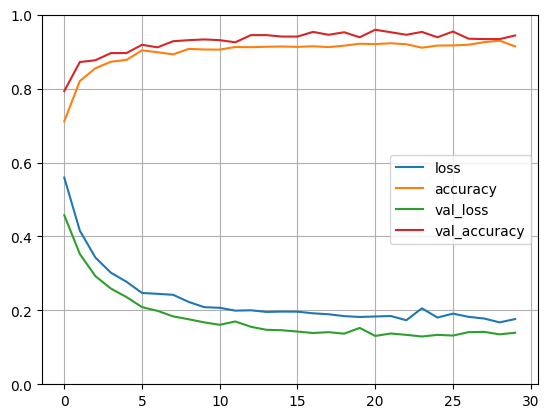

In [ ]:
og_architecture.plot_learning()

In [ ]:
og_architecture.predictions(og_architecture.X_test[:3])
print("\n", og_architecture.y_test[:3])

1/1 [==============================] - 0s 103ms/step
[[1.   0.  ]
 [1.   0.  ]
 [0.88 0.12]]

 995     0
429     0
1756    0
dtype: int64


In [ ]:
og_architecture.predictions(data_prep.interim_row_df[og_architecture.X_cols])

print("\n", data_prep.big_df[['Date', 'Adj Close']].iloc[-1], '\n', data_prep.interim_row_df[['Date', 'Adj Close']].iloc[-1])

1/1 [==============================] - 0s 21ms/step
[[0.64 0.36]]

 Date           2024-01-25
Adj Close    17516.990234
Name: 5148, dtype: object 
 Date         2024-01-26
Adj Close      17516.99
Name: 5149, dtype: object


## predictions

In [ ]:
sim_mean = price.sim_df.iloc[1,:].mean()
sim_std = price.sim_df.iloc[1,:].std()

max_price = price.sim_df.iloc[1,:].max()
min_price = price.sim_df.iloc[1,:].min()

sim_period = price.sim_df.iloc[1,:]

interim_df = pd.DataFrame()
pop_series = []

date_today = datetime.date.today().strftime("%Y-%m-%d")


for iter_price in range(int(min_price), int(max_price), 100):

    data_today = {
        'Date' : date_today,
        'Open' : iter_price,
        'High' : sim_mean + 3*sim_std,
        'Low' : sim_mean - 3*sim_std,
        'Close' : iter_price,
        'Adj Close' : iter_price,
        'Volume' : 4639979354

    ,
    }
    data_prep.interim_row(data_today)

    interim_df = pd.concat([interim_df, data_prep.interim_row_df])

    selected = sim_period[sim_period.between(iter_price, iter_price + 100)].count()
    total = sim_period.count()
    pop_series = pop_series + [np.round(selected/total,2)]

og_architecture.predictions(interim_df[og_architecture.X_cols])

price_range_pr = pd.DataFrame({
    'price' : interim_df['Close'],
    '0' : og_architecture.y_proba[:,0].round(2),
    '1' : og_architecture.y_proba[:,1].round(2),
    'pop' : pop_series
  })
#price_range_pr['pop'] = pop_series

1/1 [==============================] - 0s 31ms/step
[[1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.92 0.08]
 [0.35 0.65]
 [0.02 0.98]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]]


In [ ]:
price_range_pr

,price,0,1,pop
5149,16655.0,1.00,0.00,0.00
5149,16755.0,1.00,0.00,0.00
5149,16855.0,1.00,0.00,0.01
5149,16955.0,1.00,0.00,0.02
5149,17055.0,1.00,0.00,0.04
5149,17155.0,1.00,0.00,0.07
5149,17255.0,1.00,0.00,0.12
5149,17355.0,1.00,0.00,0.14
5149,17455.0,0.92,0.08,0.16
5149,17555.0,0.35,0.65,0.15


In [ ]:
sim_mean = price.sim_df.iloc[1,:].mean()
sim_std = price.sim_df.iloc[1,:].std()

max_price = price.sim_df.iloc[1,:].max()
min_price = price.sim_df.iloc[1,:].min()

sim_period = price.sim_df.iloc[1,:]

interim_df = pd.DataFrame()
pop_series = []

for iter_price in range(int(current_price)-50, int(current_price)+50, 10):

    data_today = {
        'Date' : date_today,
        'Open' : iter_price,
        'High' : sim_mean + 3*sim_std,
        'Low' : sim_mean - 3*sim_std,
        'Close' : iter_price,
        'Adj Close' : iter_price,
        'Volume' : 4639979354

    ,
    }
    data_prep.interim_row(data_today)

    interim_df = pd.concat([interim_df, data_prep.interim_row_df])

    selected = sim_period[sim_period.between(iter_price, iter_price + 100)].count()
    total = sim_period.count()
    pop_series = pop_series + [np.round(selected/total,2)]

og_architecture.predictions(interim_df[og_architecture.X_cols])

price_range_pr = pd.DataFrame({
    'price' : interim_df['Close'],
    '0' : og_architecture.y_proba[:,0].round(2),
    '1' : og_architecture.y_proba[:,1].round(2),
    'pop' : pop_series
  })
price_range_pr

1/1 [==============================] - 0s 21ms/step
[[0.88 0.12]
 [0.84 0.16]
 [0.85 0.15]
 [0.8  0.2 ]
 [0.73 0.27]
 [0.65 0.35]
 [0.58 0.42]
 [0.51 0.49]
 [0.42 0.58]
 [0.35 0.65]]


,price,0,1,pop
5149,17466.0,0.88,0.12,0.16
5149,17476.0,0.84,0.16,0.16
5149,17486.0,0.85,0.15,0.16
5149,17496.0,0.80,0.20,0.16
5149,17506.0,0.73,0.27,0.16
5149,17516.0,0.65,0.35,0.16
5149,17526.0,0.58,0.42,0.15
5149,17536.0,0.51,0.49,0.15
5149,17546.0,0.42,0.58,0.15
5149,17556.0,0.35,0.65,0.15


In [ ]:
current_price

17516.99

In [ ]:
sim_mean = price.sim_df.iloc[1,:].mean()
sim_std = price.sim_df.iloc[1,:].std()

max_price = price.sim_df.iloc[1,:].max()
min_price = price.sim_df.iloc[1,:].min()

sim_period = price.sim_df.iloc[1,:]

interim_df = pd.DataFrame()
pop_series = []

for iter_price in range(int(current_price)-50, int(current_price)+50, 10):

    data_today = {
        'Date' : date_today,
        'Open' : iter_price,
        'High' : sim_mean + 3*sim_std,
        'Low' : sim_mean - 3*sim_std,
        'Close' : iter_price,
        'Adj Close' : iter_price,
        'Volume' : 4639979354

    ,
    }
    data_prep.interim_row(data_today)

    interim_df = pd.concat([interim_df, data_prep.interim_row_df])

    selected = sim_period[sim_period.between(iter_price, iter_price + 100)].count()
    total = sim_period.count()
    pop_series = pop_series + [np.round(selected/total,2)]

og_architecture.predictions(interim_df[og_architecture.X_cols])

price_range_pr = pd.DataFrame({
    'price' : interim_df['Close'],
    '0' : og_architecture.y_proba[:,0].round(2),
    '1' : og_architecture.y_proba[:,1].round(2),
    'pop' : pop_series
  })

if price_range_pr['0'].iloc[-1] > 0.01:
  for iter_price in range(int(current_price)+50, int(current_price)+150, 10):

    data_today = {
        'Date' : date_today,
        'Open' : iter_price,
        'High' : sim_mean + 3*sim_std,
        'Low' : sim_mean - 3*sim_std,
        'Close' : iter_price,
        'Adj Close' : iter_price,
        'Volume' : 4639979354

    ,
    }
    data_prep.interim_row(data_today)

    interim_df = pd.concat([interim_df, data_prep.interim_row_df])

    selected = sim_period[sim_period.between(iter_price, iter_price + 100)].count()
    total = sim_period.count()
    pop_series = pop_series + [np.round(selected/total,2)]

og_architecture.predictions(interim_df[og_architecture.X_cols])

price_range_pr = pd.DataFrame({
    'price' : interim_df['Close'],
    '0' : og_architecture.y_proba[:,0].round(2),
    '1' : og_architecture.y_proba[:,1].round(2),
    'pop' : pop_series
  })
#price_range_pr = pd.concat([temp.sort_values('price'), price_range_pr.sort_values('price')])

1/1 [==============================] - 0s 20ms/step
[[0.88 0.12]
 [0.84 0.16]
 [0.85 0.15]
 [0.8  0.2 ]
 [0.73 0.27]
 [0.65 0.35]
 [0.58 0.42]
 [0.51 0.49]
 [0.42 0.58]
 [0.35 0.65]]
1/1 [==============================] - 0s 23ms/step
[[0.88 0.12]
 [0.84 0.16]
 [0.85 0.15]
 [0.8  0.2 ]
 [0.73 0.27]
 [0.65 0.35]
 [0.58 0.42]
 [0.51 0.49]
 [0.42 0.58]
 [0.35 0.65]
 [0.28 0.72]
 [0.22 0.78]
 [0.17 0.83]
 [0.13 0.87]
 [0.1  0.9 ]
 [0.08 0.92]
 [0.06 0.94]
 [0.04 0.96]
 [0.03 0.97]
 [0.02 0.98]]


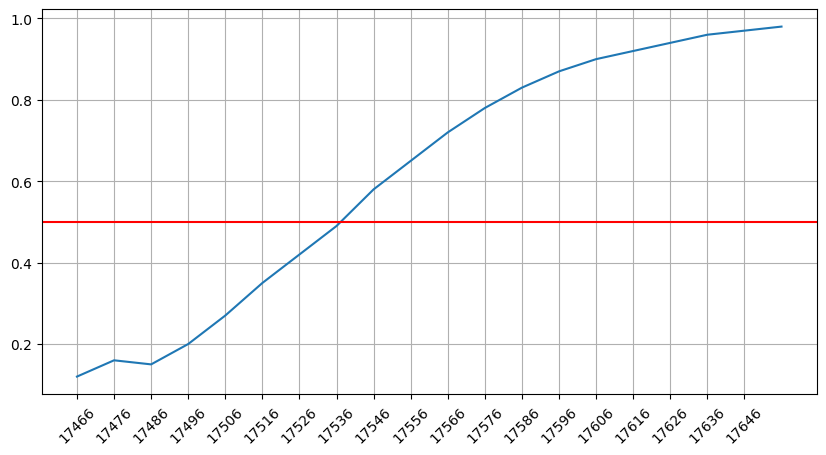

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(price_range_pr['price'], price_range_pr['1'])
plt.axhline(y = 0.5, color = 'r')
plt.xticks(np.arange(price_range_pr['price'].iloc[0], price_range_pr['price'].iloc[-1], 10))
plt.xticks(rotation=45)
plt.grid()

In [ ]:
sim_mean = price.sim_df.iloc[1,:].mean()
sim_std = price.sim_df.iloc[1,:].std()

max_price = price.sim_df.iloc[1,:].max()
min_price = price.sim_df.iloc[1,:].min()

sim_period = price.sim_df.iloc[1,:]

interim_df = pd.DataFrame()
pop_series = []

start_price = int(current_price)-50
increment = 10
iter_price = start_price

# initiation
#for iter_price in range(int(current_price)-50, int(current_price)+50, 10):


for i in range(1):
    data_today = {
        'Date' : date_today,
        'Open' : iter_price,
        'High' : sim_mean + 3*sim_std,
        'Low' : sim_mean - 3*sim_std,
        'Close' : iter_price,
        'Adj Close' : iter_price,
        'Volume' : 4639979354

    ,
    }
    data_prep.interim_row(data_today)

    interim_df = pd.concat([interim_df, data_prep.interim_row_df])

    selected = sim_period[sim_period.between(iter_price, iter_price + 100)].count()
    total = sim_period.count()
    pop_series = pop_series + [np.round(selected/total,2)]

    og_architecture.predictions(data_prep.interim_row_df[og_architecture.X_cols])
    y_proba = og_architecture.y_proba[0][0].round(2)

    print(y_proba)

while y_proba >= 0.01:

    iter_price = iter_price + 10

    data_today = {
        'Date' : date_today,
        'Open' : iter_price,
        'High' : sim_mean + 3*sim_std,
        'Low' : sim_mean - 3*sim_std,
        'Close' : iter_price,
        'Adj Close' : iter_price,
        'Volume' : 4639979354

    ,
    }
    data_prep.interim_row(data_today)

    og_architecture.predictions(data_prep.interim_row_df[og_architecture.X_cols])
    y_proba = og_architecture.y_proba[0][0].round(2)

    interim_df = pd.concat([interim_df, data_prep.interim_row_df])

    selected = sim_period[sim_period.between(iter_price, iter_price + 100)].count()
    total = sim_period.count()
    pop_series = pop_series + [np.round(selected/total,2)]

og_architecture.predictions(interim_df[og_architecture.X_cols])

price_range_pr = pd.DataFrame({
    'price' : interim_df['Close'],
    '0' : og_architecture.y_proba[:,0].round(2),
    '1' : og_architecture.y_proba[:,1].round(2),
    'pop' : pop_series
  })

1/1 [==============================] - 0s 26ms/step
[[0.88 0.12]]
0.88
1/1 [==============================] - 0s 21ms/step
[[0.84 0.16]]
1/1 [==============================] - 0s 20ms/step
[[0.85 0.15]]
1/1 [==============================] - 0s 19ms/step
[[0.8 0.2]]
1/1 [==============================] - 0s 22ms/step
[[0.73 0.27]]
1/1 [==============================] - 0s 20ms/step
[[0.65 0.35]]
1/1 [==============================] - 0s 20ms/step
[[0.58 0.42]]
1/1 [==============================] - 0s 21ms/step
[[0.51 0.49]]
1/1 [==============================] - 0s 23ms/step
[[0.42 0.58]]
1/1 [==============================] - 0s 21ms/step
[[0.35 0.65]]
1/1 [==============================] - 0s 21ms/step
[[0.28 0.72]]
1/1 [==============================] - 0s 19ms/step
[[0.22 0.78]]
1/1 [==============================] - 0s 28ms/step
[[0.17 0.83]]
1/1 [==============================] - 0s 20ms/step
[[0.13 0.87]]
1/1 [==============================] - 0s 21ms/step
[[0.1 0.9]]
1/1 [====

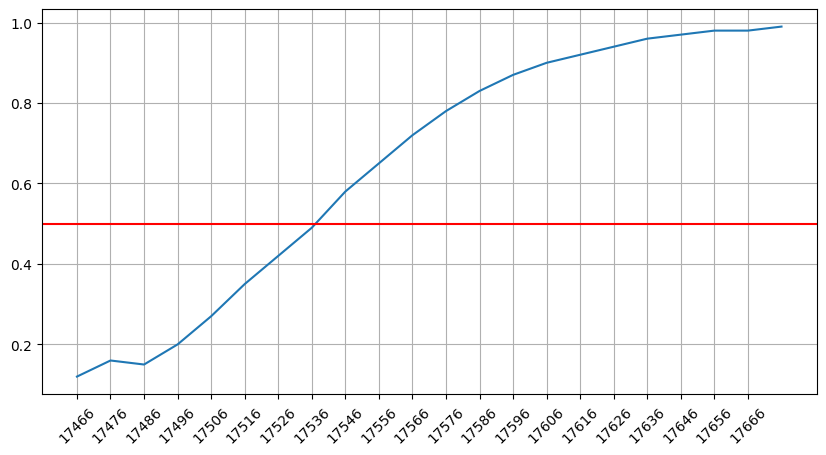

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(price_range_pr['price'], price_range_pr['1'])
plt.axhline(y = 0.5, color = 'r')
plt.xticks(np.arange(price_range_pr['price'].iloc[0], price_range_pr['price'].iloc[-1], 10))
plt.xticks(rotation=45)
plt.grid()

In [ ]:
current_price = 16830 #float(stock_price('^NDX').replace(",",""))

sim_mean = price.sim_df.iloc[1,:].mean()
sim_std = price.sim_df.iloc[1,:].std()

date_today = datetime.date.today().strftime("%Y-%m-%d")

data_today = {
    'Date' : date_today,
    'Open' : current_price,
    'High' : sim_mean + 1*sim_std,
    'Low' : sim_mean - 1*sim_std,
    'Close' : current_price, #price.sim_df.iloc[1,:].mean(),
    'Adj Close' : current_price, #price.sim_df.iloc[1,:].mean(),
    'Volume' : 4639979354
}

data_prep.interim_row(data_today)

og_architecture.predictions(data_prep.interim_row_df[og_architecture.X_cols])

print("\n", '\n', data_prep.interim_row_df[['Date', 'Adj Close']].iloc[-1])

1/1 [==============================] - 0s 21ms/step
[[1. 0.]]

 
 Date         2024-01-26
Adj Close       16830.0
Name: 5149, dtype: object


In [ ]:
data_prep.bin_target.iloc[-600:]

4549    1
4550    0
4551    0
4552    0
4553    0
       ..
5144    1
5145    1
5146    1
5147    1
5148    1
Length: 600, dtype: int64